## Week 10

In [67]:
# Samuel Harris
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

In [68]:
df = pd.read_csv('/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/data/em_dat_since2000_and_w_bank.csv')
print(df.shape)
df.head()

(15573, 44)


,DisNo.,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Event Name,ISO,Country,Subregion,...,i_mort,co2_emissions,electricity_percentage,life_expectancy,mv_gdp,mv_imort,mv_electy,mv_pop_den,mv_co2,mv_lf_exp
0,1999-9388-DJI,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,DJI,Djibouti,Sub-Saharan Africa,...,78.0,0.491842,56.119118,56.903,2.0,10.0,3.0,3.0,3.0,1.0
1,1999-9388-SDN,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,SDN,Sudan,Northern Africa,...,67.0,0.216388,23.000000,58.319,1.0,9.0,1.0,1.0,2.0,2.0
2,1999-9388-SOM,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,SOM,Somalia,Sub-Saharan Africa,...,104.5,0.055793,2.109354,50.660,NaN,10.0,1.0,1.0,1.0,1.0
3,2000-0001-AGO,tec-tra-roa-roa,Technological,Transport,Road,Road,NaN,AGO,Angola,Sub-Saharan Africa,...,121.9,0.988416,24.238865,46.024,1.0,10.0,1.0,1.0,4.0,1.0
4,2000-0002-AGO,nat-hyd-flo-riv,Natural,Hydrological,Flood,Riverine flood,NaN,AGO,Angola,Sub-Saharan Africa,...,121.9,0.988416,24.238865,46.024,1.0,10.0,1.0,1.0,4.0,1.0


### Risk Score

In [69]:
country_result = df.groupby(['Country', 'ISO'])['Disaster Type'].value_counts()
result_df = country_result.reset_index(name='count')

# Group the counts by disaster type
counts_by_disaster_type = result_df.groupby('Disaster Type')['count'].sum()


# Calculate the relative frequency for each disaster type
result_df['relative_frequency'] = result_df.apply(lambda row: row['count'] / counts_by_disaster_type[row['Disaster Type']], axis=1)


# Calculate the scaling factor for each disaster type
max_relative_frequency_by_disaster_type = result_df.groupby('Disaster Type')['relative_frequency'].max()
scaling_factors = 100 / max_relative_frequency_by_disaster_type

# Scale the relative frequency for each disaster type
result_df['scaled_relative_frequency'] = result_df.apply(lambda row: row['relative_frequency'] * scaling_factors[row['Disaster Type']], axis=1)

In [70]:
result_df2 = df.groupby(['Country', 'ISO', 'Disaster Type'])[['Total Deaths', 'Total Affected']].sum()
result_df2 = result_df2.reset_index()

result_df2['scaled_deaths'] = result_df2['Total Deaths'].clip(upper=20000)

result_df2['scaled_affected'] = result_df2['Total Affected'].clip(upper=100000)

result_df2['scaled_deaths'] = result_df2['scaled_deaths']/200
result_df2['scaled_affected'] = result_df2['scaled_affected']/1000

result_df2['Impact'] = result_df2['scaled_deaths']*.75 + result_df2['scaled_affected']*.25

result_df2

,Country,ISO,Disaster Type,Total Deaths,Total Affected,scaled_deaths,scaled_affected,Impact
0,Afghanistan,AFG,Air,290.0,26.0,1.450,0.026,1.09400
1,Afghanistan,AFG,Collapse (Industrial),50.0,35.0,0.250,0.035,0.19625
2,Afghanistan,AFG,Collapse (Miscellaneous),111.0,1055.0,0.555,1.055,0.68000
3,Afghanistan,AFG,Drought,37.0,31010000.0,0.185,100.000,25.13875
4,Afghanistan,AFG,Earthquake,4523.0,827029.0,22.615,100.000,41.96125
...,...,...,...,...,...,...,...,...
1869,Zimbabwe,ZWE,Miscellaneous accident (General),38.0,300.0,0.190,0.300,0.21750
1870,Zimbabwe,ZWE,Rail,65.0,84.0,0.325,0.084,0.26475
1871,Zimbabwe,ZWE,Road,663.0,745.0,3.315,0.745,2.67250
1872,Zimbabwe,ZWE,Storm,933.0,391084.0,4.665,100.000,28.49875


In [71]:

def flip_imort(value):
    # Define the mapping
    mapping = {10: 1, 9: 2, 8: 3, 7: 4, 6: 5, 5: 6, 4: 7, 3: 8, 2:9, 1:10 }  # Add more mappings as needed

    # Check if the value is in the mapping, otherwise return the value
    return mapping.get(value, value)

# Apply the custom function to flip the values and create a new column
df['flipped_mv_imort'] = df['mv_imort'].apply(flip_imort)

result_df3 = df.groupby(['Country', 'ISO', 'Disaster Type'])[['mv_gdp', 'mv_electy', 'mv_co2', 'mv_lf_exp', 'flipped_mv_imort']].mean()
result_df3 = result_df3.reset_index()
#result_df3.fillna(1, inplace=True)


result_df3['lack_of_resilence'] = (result_df3['mv_gdp'] + result_df3['mv_electy'] + result_df3['mv_co2'] + result_df3['mv_lf_exp']+ result_df3['flipped_mv_imort'])/(5/10)
print(result_df3['lack_of_resilence'].max(), result_df3['lack_of_resilence'].min())


97.0 10.0


In [72]:
## Transforming scale from low to high

for index, value in result_df3['lack_of_resilence'].items():
    if value == 55:
        result_df3['lack_of_resilence'][index] = value
    elif value > 55:
        result_df3['lack_of_resilence'][index] = 55 - (value - 55)
    else: 
        result_df3['lack_of_resilence'][index] = 55 + (55 - value)

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_54748/2240288211.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_54748/2240288211.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_54748/2240288211.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipyker

In [73]:
# Merge1
merged_df = pd.merge(result_df[['Country', 'ISO', 'Disaster Type', 'scaled_relative_frequency']], 
                     result_df2[['Country', 'ISO', 'Disaster Type', 'Impact']], 
                     on=['Country', 'ISO', 'Disaster Type'], 
                     how='inner')

# Merge2
final_merged_df = pd.merge(merged_df, 
                           result_df3[['Country', 'ISO','Disaster Type', 'lack_of_resilence']], 
                           on=['Country', 'ISO', 'Disaster Type'], 
                           how='inner')
final_merged_df

,Country,ISO,Disaster Type,scaled_relative_frequency,Impact,lack_of_resilence
0,Afghanistan,AFG,Flood,39.170507,38.25625,91.460864
1,Afghanistan,AFG,Earthquake,18.918919,41.96125,95.339286
2,Afghanistan,AFG,Mass movement (wet),37.500000,28.53250,88.915789
3,Afghanistan,AFG,Road,10.204082,2.33725,90.736842
4,Afghanistan,AFG,Epidemic,25.396825,38.21875,99.500000
...,...,...,...,...,...,...
1869,Zimbabwe,ZWE,Miscellaneous accident (General),10.000000,0.21750,88.666667
1870,Zimbabwe,ZWE,Rail,3.636364,0.26475,91.000000
1871,Zimbabwe,ZWE,Collapse (Industrial),3.225806,0.07525,90.000000
1872,Zimbabwe,ZWE,Industrial accident (General),1.515152,0.24375,82.000000


In [74]:

# Fit and transform 'Risk Score' column
final_merged_df['Risk Score'] = .3*final_merged_df['scaled_relative_frequency'] + .5*final_merged_df['Impact'] +  .2*final_merged_df['lack_of_resilence']
#final_merged_df[['Risk Score']] = scaler.fit_transform(final_merged_df[['Risk Score']])

# Display the normalized DataFrame
final_merged_df.sort_values(by='Risk Score', ascending=False).head(20)

,Country,ISO,Disaster Type,scaled_relative_frequency,Impact,lack_of_resilence,Risk Score
722,India,IND,Flood,89.400922,100.00000,76.582899,92.136856
319,China,CHN,Earthquake,100.000000,100.00000,43.531240,88.706248
447,Democratic Republic of the Congo,COD,Epidemic,100.000000,76.26625,99.477492,88.028623
747,Indonesia,IDN,Earthquake,69.369369,100.00000,67.332354,84.277282
1505,Somalia,SOM,Drought,40.000000,100.00000,98.800000,81.760000
1288,Philippines,PHL,Storm,52.421652,100.00000,69.539173,79.634330
1173,Nigeria,NGA,Epidemic,76.190476,74.78875,89.646623,78.180843
317,China,CHN,Flood,100.000000,73.92250,43.004652,75.562180
768,Iran (Islamic Republic of),IRN,Earthquake,49.549550,100.00000,47.322324,74.329330
1216,Pakistan,PAK,Earthquake,16.216216,100.00000,83.786765,71.622218


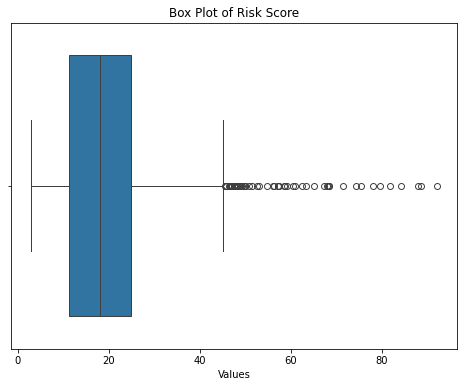

In [75]:
# Select the column for which you want to create a box plot
column_name = 'Risk Score'

# Plot box plot for the selected column
plt.figure(figsize=(8, 6))  # Set the size of the plot
sns.boxplot(x=final_merged_df[column_name])
plt.title(f'Box Plot of {column_name}')
plt.xlabel('Values')
plt.show()

In [76]:
# Define bins and labels
bins = [-float('inf'), 9, 25, 35, 50, float('inf')]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

# Add new column with bin labels
final_merged_df['Category'] = pd.cut(final_merged_df['Risk Score'], bins=bins, labels=labels, right=False)
final_merged_df

,Country,ISO,Disaster Type,scaled_relative_frequency,Impact,lack_of_resilence,Risk Score,Category
0,Afghanistan,AFG,Flood,39.170507,38.25625,91.460864,49.171450,High
1,Afghanistan,AFG,Earthquake,18.918919,41.96125,95.339286,45.724158,High
2,Afghanistan,AFG,Mass movement (wet),37.500000,28.53250,88.915789,43.299408,High
3,Afghanistan,AFG,Road,10.204082,2.33725,90.736842,22.377218,Low
4,Afghanistan,AFG,Epidemic,25.396825,38.21875,99.500000,46.628423,High
...,...,...,...,...,...,...,...,...
1869,Zimbabwe,ZWE,Miscellaneous accident (General),10.000000,0.21750,88.666667,20.842083,Low
1870,Zimbabwe,ZWE,Rail,3.636364,0.26475,91.000000,19.423284,Low
1871,Zimbabwe,ZWE,Collapse (Industrial),3.225806,0.07525,90.000000,19.005367,Low
1872,Zimbabwe,ZWE,Industrial accident (General),1.515152,0.24375,82.000000,16.976420,Low


In [77]:
import plotly.graph_objs as go
import pandas as pd
import os

# Group by ISO, Country and filter for rows with the maximum Risk Score within each group
top_scores = final_merged_df.dropna().groupby(['ISO', 'Country'])['Risk Score'].idxmax()
top_scores = final_merged_df.loc[top_scores]

# Define a mapping from categories to numerical values
category_mapping = {
    'Very Low': 1,
    'Low': 2,
    'Moderate': 3,
    'High': 4,
    'Very High': 5
}

# Map categories to numerical values
top_scores['Category Numerical'] = top_scores['Category'].map(category_mapping)

# Define colors for each category
category_colors = {
    'Very Low': 'rgb(173,216,230)',   # Light blue
    'Low': 'rgb(0,0,255)',             # Blue
    'Moderate': 'rgb(255, 255, 0)', # Yellow
    'High': 'rgb(255, 165, 0)', # Orange
    'Very High': 'rgb(255, 0, 0)'   # Red
}

# Create a Plotly choropleth map
fig = go.Figure(data=go.Choropleth(
    locations=top_scores['ISO'],  # ISO codes of countries
    z=top_scores['Category Numerical'],  # Numerical category values to be color-coded
    text=top_scores.apply(lambda row: f"Country: {row['Country']}<br>Risk Score: {round(row['Risk Score'], 2)}<br>Category: {row['Category']}<br>Disaster Type: {row['Disaster Type']}", axis=1),  # Text to display on hover including country, rounded risk score, category, and disaster type
    colorscale=[[i/(len(category_mapping)-1), category_colors[cat]] for i, cat in enumerate(category_mapping.keys())],
    autocolorscale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title='Risk Category',
    marker=dict(
        line=dict(color='rgb(180,180,180)', width=0.5),  # Specify marker line properties
    )
))

fig.update_layout(
    title_text='Global Risk Score by Country (Top from each Disaster Type)',
    geo=dict(
        showcoastlines=True,  # Show coastlines
    )
)

fig.show()

# Define the folder path where you want to save the HTML file
folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

# Ensure that the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_path, 'risk_score_map.html')

# Save the figure as HTML file
fig.write_html(file_path)



## geo encoding

In [78]:
df_test = df.copy()

### Test

from geopy.geocoders import Nominatim

# Initialize Nominatim geocoder
geolocator = Nominatim(user_agent="my_geocoder")

# Example address (replace with your country, state, and province information)
address =  "Gaziantep, Turkey"

# Geocode the address
location = geolocator.geocode(address)

# Extract latitude and longitude
latitude = location.latitude
longitude = location.longitude

# Print latitude and longitude
print("Latitude:", latitude)
print("Longitude:", longitude)


Latitude: 36.9666307
Longitude: 37.4074178


In [79]:
def concatenate_country_location(row):
    location = row['Location']
    if isinstance(location, str):  # Check if 'Location' is a string and not NaN
        # Find the indices of the first comma and opening parentheses in the location string
        comma_idx = location.find(',')
        paren_idx = location.find('(')
        # Determine the stopping index (minimum of comma index and parenthesis index)
        stop_idx = min(comma_idx, paren_idx) if comma_idx != -1 and paren_idx != -1 else max(comma_idx, paren_idx)
        if stop_idx != -1:
            # If a comma or parentheses is found, discard everything after it
            first_location_part = location[:stop_idx].strip()
        else:
            # If neither a comma nor parentheses is found, use the entire location string
            first_location_part = location.strip()
            
        # Remove specified words from the first part of the location
        words_to_remove = ['area', 'provinces', 'province', 'village']
        first_location_part_words = first_location_part.split()
        first_location_part_words = [word for word in first_location_part_words if word.lower() not in words_to_remove]
        first_location_part = ' '.join(first_location_part_words)
        
        # Remove 'and' and anything after it if it appears in the first part of the location
        if 'and' in first_location_part:
            first_location_part = first_location_part.split('and')[0].strip()
        
        # Concatenate 'Country' with the modified first part of location
        return f"{row['Country']}, {first_location_part}"
    else:
        # If 'Location' is not a string (NaN), return the 'Country' value
        return row['Country']


# Apply the function to create a new column
df_test['Country_Location'] = df_test.apply(concatenate_country_location, axis=1)

# Display the DataFrame
df_test['Country_Location'].tail(20)

15553                       South Africa, Dundee City
15554                                     China, Jixi
15555                        Indonesia, Nusa Tengarra
15556                            Nicaragua, Rancho Gr
15557                             Indonesia, Morowali
15558                                 Malaysia, Johor
15559                                 Thailand, Satun
15560                         South Africa, Ladysmith
15561                      Australia, New South Wales
15562        Democratic Republic of the Congo, Bukavu
15563       Democratic Republic of the Congo, Kananga
15564                                 Liberia, Totota
15565                                    France, Nord
15566                                 Congo, Likouala
15567                             Honduras, Choculeta
15568                               Spain, Catalognia
15569                              Indonesia, Lampung
15570                            Uruguay, Cerro Largo
15571                       

In [80]:
# Initialize Nominatim geocoder
geolocator = Nominatim(user_agent="my_geocoder")

# Function to geocode place names and return latitude and longitude
def geocode_place(place):
    location = geolocator.geocode(place)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Apply geocoding to the 'Place' column
Latitude, Longitude = geocode_place(df_test['Country_Location'][14])

print(Latitude, Longitude)

-26.45969795 32.574586008699036


In [81]:

def flip_imort(value):
    # Define the mapping
    mapping = {10: 1, 9: 2, 8: 3, 7: 4, 6: 5, 5: 6, 4: 7, 3: 8, 2:9, 1:10 }  # Add more mappings as needed

    # Check if the value is in the mapping, otherwise return the value
    return mapping.get(value, value)

# Apply the custom function to flip the values and create a new column
df_test['flipped_mv_imort'] = df_test['mv_imort'].apply(flip_imort)

df_test['country_devlopment_score'] = df_test['mv_gdp'] + df_test['mv_electy'] + df_test['mv_co2'] + df_test['mv_lf_exp'] + df_test['flipped_mv_imort']


mean_scores_by_country = df_test.groupby('Country')['country_devlopment_score'].mean()

# Fill NaN values in 'country_devlopment_score' with the mean values for each country
df_test['country_devlopment_score'] = df_test.apply(lambda row: mean_scores_by_country[row['Country']] if pd.isna(row['country_devlopment_score']) else row['country_devlopment_score'], axis=1)

# Plot


df_test.drop(columns=['Latitude', 'Longitude'], inplace=True)


In [82]:
df_test['country_devlopment_score'] = df_test['country_devlopment_score'].fillna(0).astype(int)
df_test['country_devlopment_score'].replace(0, np.nan, inplace=True)

In [83]:
df_test['country_devlopment_score'].min()

5.0

In [84]:
df_least_developed = df_test[df_test['country_devlopment_score'] < 20]
df_developing = df_test[(df_test['country_devlopment_score'] >= 20) & (df_test['country_devlopment_score'] <= 35)]
df_developed = df_test[df_test['country_devlopment_score'] > 35]

In [85]:
import plotly.express as px
df_least_developed_top_20 = df_least_developed.nlargest(20, 'Total Deaths')

df_least_developed_top_20.loc[3940, 'Country_Location'] = 'Indonesia, Aceh'
df_least_developed_top_20.loc[9650, 'Country_Location'] = 'India, Uttarakhand'
df_least_developed_top_20.loc[3769, 'Country_Location'] = 'Haiti'

from geopy.geocoders import Nominatim
import time
# Function to geocode place names and return latitude and longitude
def geocode_place(place):
    time.sleep(.1)  # Adding a delay of .25 second
    location = geolocator.geocode(place)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Apply geocoding to the 'Country_Location' column
df_least_developed_top_20['latitude'], df_least_developed_top_20['longitude'] = zip(*df_least_developed_top_20['Country_Location'].apply(geocode_place))



In [86]:
import plotly.express as px
df_developing_top_20 = df_developing.nlargest(20, 'Total Deaths')

df_developing_top_20.loc[15091, 'Country_Location'] = 'Gaziantep, Turkey'
df_developing_top_20.loc[3159, 'Country_Location'] = 'Bam, Iran'
df_developing_top_20.loc[12610, 'Country_Location'] = 'Donggala, Indonesia'
from geopy.geocoders import Nominatim
import time
# Function to geocode place names and return latitude and longitude
def geocode_place(place):
    time.sleep(.1)  # Adding a delay of .25 second
    location = geolocator.geocode(place)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Apply geocoding to the 'Country_Location' column
df_developing_top_20 ['latitude'], df_developing_top_20 ['longitude'] = zip(*df_developing_top_20 ['Country_Location'].apply(geocode_place))


In [87]:
import plotly.express as px
df_developed_top_20 = df_developed.nlargest(20, 'Total Deaths')

df_developed_top_20.loc[2925, 'Country_Location'] = 'Andalucia, Spain'
df_developed_top_20.loc[14773, 'Country_Location'] = 'Athens, Greece'

from geopy.geocoders import Nominatim
import time
# Function to geocode place names and return latitude and longitude
def geocode_place(place):
    time.sleep(.1)  # Adding a delay of .25 second
    location = geolocator.geocode(place)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Apply geocoding to the 'Country_Location' column
df_developed_top_20 ['latitude'], df_developed_top_20 ['longitude'] = zip(*df_developed_top_20 ['Country_Location'].apply(geocode_place))


In [88]:
import plotly.express as px
fig_developed = px.scatter_geo(df_developed_top_20, 
                     lat="latitude", 
                     lon="longitude", 
                     color="Disaster Subtype",
                     hover_name="Country", 
                     hover_data={"latitude": False, "longitude": False, "Region": True, "Country": True, "Total Deaths": True, "Disaster Subtype": True,
                                'Start Year':True, 'Start Month': True},
                     size="Total Deaths",
                     projection="natural earth")

fig_developing = px.scatter_geo(df_developing_top_20, 
                     lat="latitude", 
                     lon="longitude", 
                     color="Disaster Subtype",
                     hover_name="Country", 
                     hover_data={"latitude": False, "longitude": False, "Region": True, "Country": True, "Total Deaths": True, "Disaster Subtype": True,
                                'Start Year':True, 'Start Month': True},
                     size="Total Deaths",
                     projection="natural earth")

fig_least_developed = px.scatter_geo(df_least_developed_top_20, 
                     lat="latitude", 
                     lon="longitude", 
                     color="Disaster Subtype",
                     hover_name="Country", 
                     hover_data={"latitude": False, "longitude": False, "Region": True, "Country": True, "Total Deaths": True, "Disaster Subtype": True,
                                'Start Year':True, 'Start Month': True},
                     size="Total Deaths",
                     projection="natural earth")


In [89]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import os

# Create figures for each dataset
fig_developed = px.scatter_geo(df_developed_top_20, 
                     lat="latitude", 
                     lon="longitude", 
                     color="Disaster Subtype",
                     hover_name="Country", 
                     hover_data={"latitude": False, "longitude": False, "Region": True, "Country": True, "Total Deaths": True, "Disaster Subtype": True,
                                'Start Year':True, 'Start Month': True},
                     size="Total Deaths",
                     projection="natural earth")

fig_developing = px.scatter_geo(df_developing_top_20, 
                     lat="latitude", 
                     lon="longitude", 
                     color="Disaster Subtype",
                     hover_name="Country", 
                     hover_data={"latitude": False, "longitude": False, "Region": True, "Country": True, "Total Deaths": True, "Disaster Subtype": True,
                                'Start Year':True, 'Start Month': True},
                     size="Total Deaths",
                     projection="natural earth")

fig_least_developed = px.scatter_geo(df_least_developed_top_20, 
                     lat="latitude", 
                     lon="longitude", 
                     color="Disaster Subtype",
                     hover_name="Country", 
                     hover_data={"latitude": False, "longitude": False, "Region": True, "Country": True, "Total Deaths": True, "Disaster Subtype": True,
                                'Start Year':True, 'Start Month': True},
                     size="Total Deaths",
                     projection="natural earth")

# Create dropdown menu
dropdown_menu = [{'label': 'Developed', 'method': 'update', 'args': [{'visible': [True] * len(fig_developed.data) + [False] * len(fig_developing.data) + [False] * len(fig_least_developed.data)}]},
                 {'label': 'Developing', 'method': 'update', 'args': [{'visible': [False] * len(fig_developed.data) + [True] * len(fig_developing.data) + [False] * len(fig_least_developed.data)}]},
                 {'label': 'Least Developed', 'method': 'update', 'args': [{'visible': [False] * len(fig_developed.data) + [False] * len(fig_developing.data) + [True] * len(fig_least_developed.data)}]}]

# Create subplots
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scattergeo'}]])

# Add traces from each original figure
for trace in fig_developed.data:
    fig.add_trace(trace)

for trace in fig_developing.data:
    fig.add_trace(trace)

for trace in fig_least_developed.data:
    fig.add_trace(trace)

# Set visibility for each trace
for i in range(len(fig_developed.data)):
    fig.data[i].visible = True

for i in range(len(fig_developed.data), len(fig_developed.data) + len(fig_developing.data)):
    fig.data[i].visible = False

for i in range(len(fig_developed.data) + len(fig_developing.data), len(fig.data)):
    fig.data[i].visible = False

fig.update_layout(
    {'updatemenus':[{'buttons':dropdown_menu, 'direction': 'down', 'showactive': True}]},
    title="Highest Death Toll Natural Disasters by Development Status"
)

fig.show()

# Define the folder path where you want to save the HTML file
folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

# Ensure that the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_path, 'development_map_with_tab.html')

# Save the figure as HTML file
fig.write_html(file_path)

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your data into a DataFrame called df_test

# Binning country development score into three categories
df_test['Development_Category'] = pd.cut(df_test['country_devlopment_score'], bins=[0, 20, 35, float('inf')], labels=['Least Developed', 'Developing', 'Developed'])

# Get top ten disaster types
top_disaster_types = df_test['Disaster Type'].value_counts().nlargest(10).index.tolist()

# Grouping data by 'Development_Category' and 'Disaster Type', and summing 'Total Deaths'
grouped_data = df_test[df_test['Disaster Type'].isin(top_disaster_types)].groupby(['Development_Category', 'Disaster Type'])['Total Deaths'].sum().unstack()

# Adding 'Other' category for remaining disaster types
other_disaster_types = list(set(df_test['Disaster Type']) - set(top_disaster_types))
grouped_data['Other'] = df_test[df_test['Disaster Type'].isin(other_disaster_types)].groupby('Development_Category')['Total Deaths'].sum()

import plotly.express as px

# Assuming 'grouped_data' is your DataFrame containing the grouped data

fig = px.bar(grouped_data, barmode='stack', labels={'value': 'Total Deaths', 'index': 'Development_Category'},
             title='Total Deaths by Development Category and Top Ten Disaster Types',
             color_discrete_sequence=px.colors.qualitative.Light24)

fig.update_layout(xaxis_title='Development Category', yaxis_title='Total Deaths', legend_title='Disaster Type')

fig.update_traces(marker=dict(line=dict(width=1)), width=0.4)

fig.show()

# Define the folder path where you want to save the HTML file
folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

# Ensure that the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_path, 'bar_chart_with_development_category_and_disaster_type.html')

# Save the figure as HTML file
fig.write_html(file_path)

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_54748/640026638.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_54748/640026638.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



##### We are excluding some countries here

In [91]:
import pandas as pd
import plotly.express as px

# Assuming you have loaded your data into a DataFrame called df_test

# Binning country development score into three categories
df_test['Development_Category'] = pd.cut(df_test['country_devlopment_score'], bins=[0, 20, 35, float('inf')], labels=['Least Developed', 'Developing', 'Developed'])

# Grouping data by 'Start Year' and 'Development_Category', and summing 'Total Deaths'
grouped_data = df_test.groupby(['Start Year', 'Development_Category'])['Total Deaths'].sum().reset_index()

# Creating the line plot using Plotly Express
fig = px.line(grouped_data, x='Start Year', y='Total Deaths', color='Development_Category',
              labels={'Start Year': 'Start Year', 'Total Deaths': 'Total Deaths', 'Development_Category': 'Development Category'},
              title='Total Deaths by Start Year and Development Category',
              markers = True)

fig.update_layout(xaxis_title='Start Year', yaxis_title='Total Deaths', legend_title='Development Category')

fig.show()

# Define the folder path where you want to save the HTML file
folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

# Ensure that the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_path, 'line_plot_with_start_year_and_development_category.html')

# Save the figure as HTML file
fig.write_html(file_path)


/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_54748/114371930.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/samharris/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [92]:
import pandas as pd
import plotly.express as px

# Assuming you have loaded your data into a DataFrame called df_test

# Binning country development score into three categories
df_test['Development_Category'] = pd.cut(df_test['country_devlopment_score'], bins=[0, 20, 35, float('inf')], labels=['Least Developed', 'Developing', 'Developed'])

# Get top ten disaster types
top_disaster_types = df_test['Disaster Type'].value_counts().nlargest(10).index.tolist()

# Assign 'Other' category for remaining disaster types
df_test.loc[~df_test['Disaster Type'].isin(top_disaster_types), 'Disaster Type'] = 'Other'

# Counting number of disasters for each development category and disaster type
disasters_count = df_test.groupby(['Development_Category', 'Disaster Type']).size().unstack(fill_value=0)

# Plotting using Plotly Express
fig = px.bar(disasters_count, x=disasters_count.index, y=top_disaster_types + ['Other'], 
             title='Number of Disasters for Each Development Category',
             labels={'x': 'Development Category', 'y': 'Number of Disasters'},
             color_discrete_sequence=px.colors.qualitative.Safe,
             barmode='group')

fig.update_layout(xaxis_title='Development Category', yaxis_title='Number of Disasters', legend_title='Disaster Type')

fig.update_traces(marker=dict(line=dict(width=1)))

fig.show()

# Define the folder path where you want to save the HTML file
folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

# Ensure that the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_path, 'number_of_disaster_development_category.html')

# Save the figure as HTML file
fig.write_html(file_path)



/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_54748/2286606992.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Week 11

In [93]:
from scipy.stats import f_oneway
import pandas as pd
df_test['Total Deaths'] = df_test['Total Deaths'].fillna(0)
df_test = df_test.dropna(subset=['Development_Category'])


# Assuming df_test is your DataFrame
# Extract 'Total Deaths' column and 'Development_Category' column
total_deaths = df_test['Total Deaths']
development_category = df_test['Development_Category']

# Create a dictionary to hold 'Total Deaths' for each category
category_data = {}
for category in development_category.unique():
    category_data[category] = total_deaths[development_category == category]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*category_data.values())

# Print the results
print("ANOVA Results:")
print("F-Statistic:", f_statistic)
print("P-value:", p_value)


ANOVA Results:
F-Statistic: 2.1597770054193055
P-value: 0.11538609272841485


In [94]:
means_by_category = df_test.groupby('Development_Category')['Total Deaths'].mean()
print(means_by_category)
medians_by_category = df_test.groupby('Development_Category')['Total Deaths'].median()
print(medians_by_category)
counts_by_category = df_test.groupby('Development_Category')['Total Deaths'].count()
print(counts_by_category)

Development_Category
Least Developed    167.726352
Developing          74.394391
Developed           67.565559
Name: Total Deaths, dtype: float64
Development_Category
Least Developed    17.0
Developing         12.0
Developed           5.0
Name: Total Deaths, dtype: float64
Development_Category
Least Developed    6322
Developing         5634
Developed          3310
Name: Total Deaths, dtype: int64


/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_54748/3923214446.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_54748/3923214446.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/lg/vpwp92v96rsbh9x3s5fyjd9w0000gn/T/ipykernel_54748/3923214446.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [95]:
from scipy.stats import ttest_ind

# Define the groups for comparison
developed = df_test[df_test['Development_Category'] == 'Developed']['Total Deaths']
developing = df_test[df_test['Development_Category'] == 'Developing']['Total Deaths']
least_developed = df_test[df_test['Development_Category'] == 'Least Developed']['Total Deaths']

# Perform t-tests for Group 1 vs. Group 2, Group 1 vs. Group 3, and Group 2 vs. Group 3
t_statistic_1_2, p_value_1_2 = ttest_ind(developed, developing)
t_statistic_1_3, p_value_1_3 = ttest_ind(developed, least_developed)
t_statistic_2_3, p_value_2_3 = ttest_ind(developing, least_developed)

# Print the results
print("developed  vs. developing")
print("T-Statistic:", t_statistic_1_2)
print("P-Value:", p_value_1_2)
print()

print("developed  vs. least_developed:")
print("T-Statistic:", t_statistic_1_3)
print("P-Value:", p_value_1_3)
print()

print("developing vs least_developed:")
print("T-Statistic:", t_statistic_2_3)
print("P-Value:", p_value_2_3)



developed  vs. developing
T-Statistic: -0.2299075150160351
P-Value: 0.8181688953679274

developed  vs. least_developed:
T-Statistic: -1.4054072220008136
P-Value: 0.15993247967126203

developing vs least_developed:
T-Statistic: -1.6179734434640076
P-Value: 0.10569470411194096


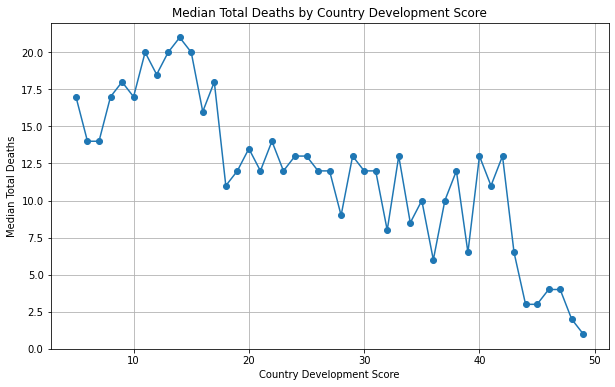

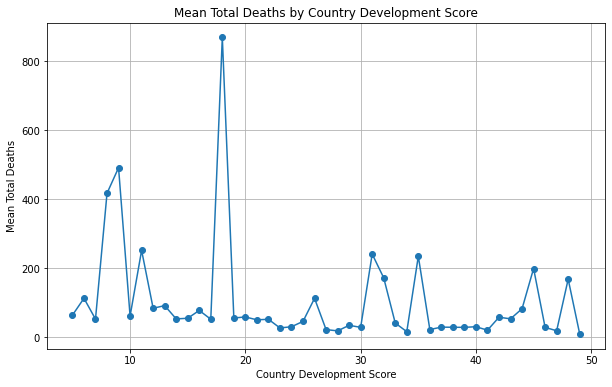

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_test_1 contains your dataset

# Calculate mean Total Deaths for each value of country_developlment_score
median_deaths_by_score = df_test.groupby('country_devlopment_score')['Total Deaths'].median()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(median_deaths_by_score.index, median_deaths_by_score.values, marker='o', linestyle='-')
plt.xlabel('Country Development Score')
plt.ylabel('Median Total Deaths')
plt.title('Median Total Deaths by Country Development Score')
plt.grid(True)
plt.show()

# Calculate mean Total Deaths for each value of country_developlment_score
mean_deaths_by_score = df_test.groupby('country_devlopment_score')['Total Deaths'].mean()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(mean_deaths_by_score.index, mean_deaths_by_score.values, marker='o', linestyle='-')
plt.xlabel('Country Development Score')
plt.ylabel('Mean Total Deaths')
plt.title('Mean Total Deaths by Country Development Score')
plt.grid(True)
plt.show()

In [97]:
import plotly.graph_objs as go
import pandas as pd

# Assuming df_test_1 contains your dataset

# Calculate mean Total Deaths for each value of country_development_score
#median_deaths_by_score = df_test.groupby('country_development_score')['Total Deaths'].median()

# Plot
fig = go.Figure(data=go.Scatter(x=median_deaths_by_score.index, y=median_deaths_by_score.values, mode='lines+markers'))
fig.update_layout(
    title='Median Total Deaths by Country Development Score',
    xaxis=dict(tickmode='linear', tick0=0, dtick=10),  # Adjust the tick frequency as needed
    yaxis=dict(tickmode='linear', tick0=0, dtick=2.5),  # Adjust the tick frequency as needed
    xaxis_title='Country Development Score',
    yaxis_title='Median Total Deaths',
    showlegend=False,
    hovermode='x unified'
)
fig.show()

# Define the folder path where you want to save the HTML file
folder_path = "/Users/samharris/Desktop/Capstone/24Spr_-S-Harris-_-disasters-/Sample_Capstone/code/website/"

# Ensure that the folder exists
os.makedirs(folder_path, exist_ok=True)

# Define the file path
file_path = os.path.join(folder_path, 'median_total_deaths_by_dev_score.html')

# Save the figure as HTML file
fig.write_html(file_path)

# Calculate mean Total Deaths for each value of country_development_score
#mean_deaths_by_score = df_test.groupby('country_development_score')['Total Deaths'].mean()

# Plot
fig = go.Figure(data=go.Scatter(x=mean_deaths_by_score.index, y=mean_deaths_by_score.values, mode='lines+markers'))
fig.update_layout(
    title='Mean Total Deaths by Country Development Score',
    xaxis=dict(tickmode='linear', tick0=0, dtick=2),  # Adjust the tick frequency as needed
    yaxis=dict(tickmode='linear', tick0=0, dtick=200),  # Adjust the tick frequency as needed
    xaxis_title='Country Development Score',
    yaxis_title='Mean Total Deaths',
    showlegend=False,
    hovermode='x unified'
)
fig.show()




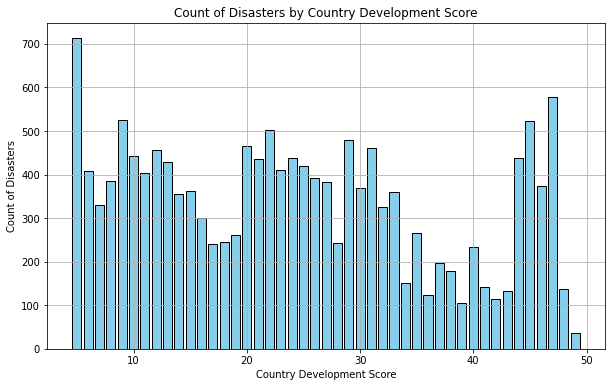

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate count of disasters for each value of country_development_score
disaster_count_by_score = df_test['country_devlopment_score'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(disaster_count_by_score.index, disaster_count_by_score.values, color='skyblue', edgecolor='black')
plt.xlabel('Country Development Score')
plt.ylabel('Count of Disasters')
plt.title('Count of Disasters by Country Development Score')
plt.grid(True)
plt.show()


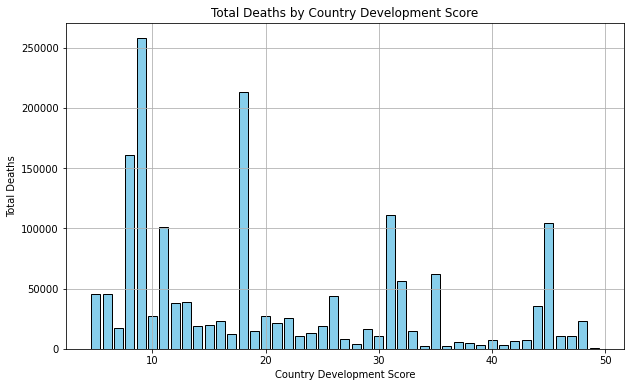

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_test contains your dataset

# Calculate total deaths for each value of country_development_score
total_deaths_by_score = df_test.groupby('country_devlopment_score')['Total Deaths'].sum()

# Plot histogram of Total Deaths by country_development_score
plt.figure(figsize=(10, 6))
plt.bar(total_deaths_by_score.index, total_deaths_by_score.values, color='skyblue', edgecolor='black')
plt.xlabel('Country Development Score')
plt.ylabel('Total Deaths')
plt.title('Total Deaths by Country Development Score')
plt.grid(True)
plt.show()

